Using matplotlib backend: TkAgg
1278


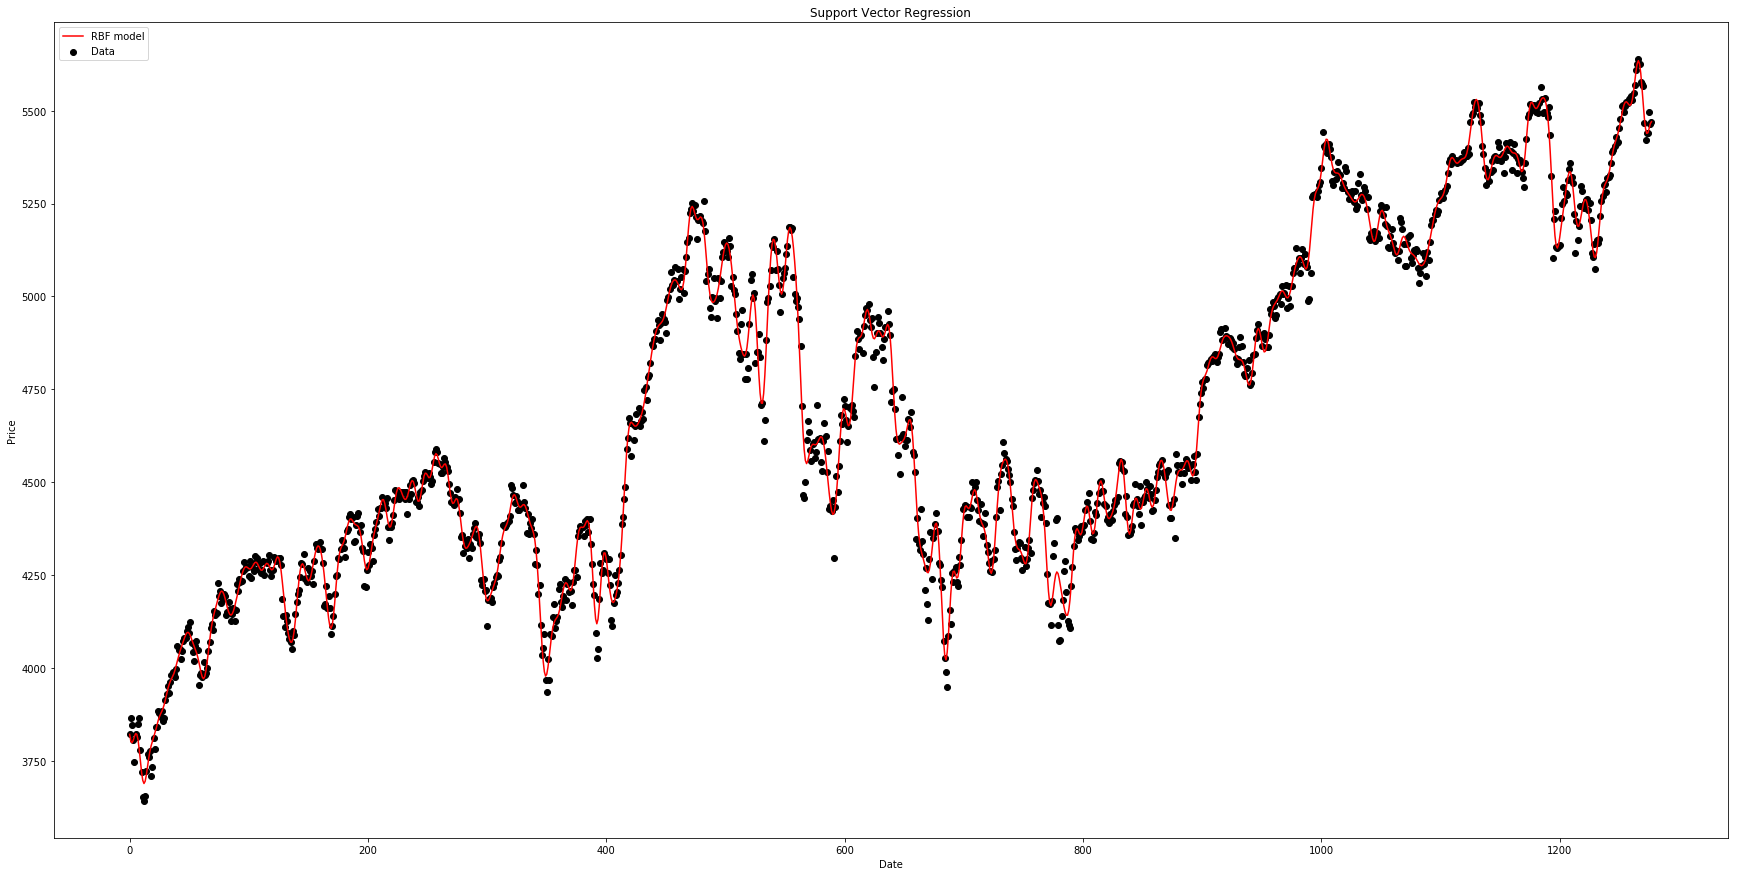

1278
5460.75196507237


In [43]:
# SVR
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30.0, 15.0)

import csv
import numpy as np
from sklearn.svm import SVR


dates = []
real_dates = []
prices = []

i = 0

def read_data(filename):
    global i
    i = 0
    with open(filename, 'r') as csvFile:
        csvFileReader = csv.reader(csvFile)
        next(csvFileReader)
        for row in csvFileReader:
            real_dates.append(row[0])
            dates.append(i)
            prices.append(float(row[1]))
            i = i+1
        print(i)
    return

def price_prediction_model(dates, prices, x):
    dates = np.reshape(dates, (len(dates),1))
    svr_rbf = SVR(kernel='rbf',C=1e4, gamma = 0.01464)
        
    svr_rbf.fit(dates,prices)
    
    plt.scatter(dates, prices, color='black', label='Data')
    plt.plot(dates, svr_rbf.predict(dates), color='red', label='RBF model')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.savefig('test.png', bbox_inches='tight')
    plt.show()
    return svr_rbf.predict(x)[0] 

read_data('CAC40_5Y.csv')

predicted_price = price_prediction_model(dates, prices, i)

print(i)
print(predicted_price)
#SVM not very good at price prediction with 1YR data set
#SVM not very good at price prediction with 5YR data set


In [1]:

"""
NEAT evloving a TraderGenome able to buy/sell/hodl fit for maximum returns
Strategy :  if output in :
                - ]-1, -0.33[ then sell
                - [-0.33, 0.33] then hodl
                - ]0.33, 1[ then buy
"""

from __future__ import print_function
import os
import neat
import visualize
import csv
import math
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


# custom gene with buy_count,sell_count and hodl_count
class TraderGenome(neat.DefaultGenome):
    def __init__(self, key):
        super().__init__(key)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def configure_new(self, config):
        super().configure_new(config)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def configure_crossover(self, genome1, genome2, config):
        super().configure_crossover(genome1, genome2, config)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def mutate(self, config):
        super().mutate(config)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def __str__(self):
        return "buy_count: {0}, sell_count: {1}, hodl_count: {2}\n{3}".format(self.buy_count,self.sell_count,self.hodl_count, super().__str__())



# Date, Open, High, Low, Close, Volume
# training data of CAC40 from 2005-06-13 till 2017-06-13
input_training_data = []

# training data of CAC40 from 2017-06-14 till 2018-06-11
input_testing_data = []

# 1 -> buy
# -1 -> sell
# 0 -> hodl
def decide(res):
    if (res > 0.33):
        return 1.0
    elif (res < -0.33):
        return -1.0
    else:
        return 0.0

def normalize_data(data_array):
    data_norm = []
    minx = min(data_array)
    maxx = max(data_array)
    for data in data_array:
        data_norm.append(2*((data-minx)/(maxx-minx))-1)
    return data_norm, minx, maxx

def load_data_from_csv(filename):
    data = []
    data_open = []
    data_high = []
    data_low = []
    data_close = []
    data_volume = []
    with open(filename, 'r') as File:  
        reader = csv.reader(File)
        for row in reader:
            data.append((round(float(row[1]),2),round(float(row[2]),2),round(float(row[3]),2),round(float(row[4]),2),round(float(row[5]),2)))
            data_open.append(round(float(row[1]),2))
            data_high.append(round(float(row[2]),2))
            data_low.append(round(float(row[3]),2))
            data_close.append(round(float(row[4]),2))
            data_volume.append(round(float(row[5]),2))
    return data, data_open,data_high,data_low,data_close,data_volume
            
    
def combine_arrays(arr1,arr2,arr3,arr4,arr5,):
    index = len(arr1)
    output = []
    for i in range(0,index):
        output.append((arr1[i],arr2[i],arr3[i],arr4[i],arr5[i]))
    return output


input_training_data,input_training_data_open,input_training_data_high,input_training_data_low,input_training_data_close,input_training_data_volume = load_data_from_csv('CAC40_2005_2017.csv')
input_testing_data,input_testing_data_open,input_testing_data_high,input_testing_data_low,input_testing_data_close,input_testing_data_volume = load_data_from_csv('CAC40_2017_2018.csv')


input_training_data_open_norm, input_training_data_open_minx, input_training_data_open_maxx = normalize_data(input_training_data_open)
input_training_data_high_norm, input_training_data_high_minx, input_training_data_high_maxx = normalize_data(input_training_data_high)
input_training_data_low_norm, input_training_data_low_minx, input_training_data_low_maxx = normalize_data(input_training_data_low)
input_training_data_close_norm, input_training_data_close_minx, input_training_data_close_maxx = normalize_data(input_training_data_close)
input_training_data_volume_norm, input_training_data_volume_minx, input_training_data_volume_maxx = normalize_data(input_training_data_volume)


input_testing_data_open_norm, input_testing_data_open_minx, input_testing_data_open_maxx = normalize_data(input_testing_data_open)
input_testing_data_high_norm, input_testing_data_high_minx, input_testing_data_high_maxx = normalize_data(input_testing_data_high)
input_testing_data_low_norm, input_testing_data_low_minx, input_testing_data_low_maxx = normalize_data(input_testing_data_low)
input_testing_data_close_norm, input_testing_data_close_minx, input_testing_data_close_maxx = normalize_data(input_testing_data_close)
input_testing_data_volume_norm, input_testing_data_volume_minx, input_testing_data_volume_maxx = normalize_data(input_testing_data_volume)


    
input_training_data_norm = combine_arrays(input_training_data_open_norm,
                                          input_training_data_high_norm,
                                          input_training_data_low_norm,
                                          input_training_data_close_norm,
                                          input_training_data_volume_norm)

input_testing_data_norm = combine_arrays(input_testing_data_open_norm,
                                          input_testing_data_high_norm,
                                          input_testing_data_low_norm,
                                          input_testing_data_close_norm,
                                          input_testing_data_volume_norm)


def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        money = 100000.0
        genome.fitness = 0
        shares = 0
        net = neat.nn.RecurrentNetwork.create(genome, config)
        size = len(input_training_data)
        genome.buy_count = 0
        genome.sell_count = 0
        genome.hodl_count = 0
        for i, input_data in enumerate(input_training_data_norm):
            if (i < size-1):
                #input_data = (input_data) + (shares,money,)
                output = net.activate(input_data)
                decision = decide(output[0]) #-1: sell | 0: HODL | 1: buy
                if (decision == -1 and shares > 0):
                    shares = shares-1
                    money = money + input_training_data[i+1][0] #Sell on market open
                    genome.sell_count = genome.sell_count+1
                
                elif (decision == 1 and money > input_training_data[i+1][0]):
                    shares = shares+1
                    money = money - input_training_data[i+1][0] #Buy on market open
                    genome.buy_count = genome.buy_count+1
                else: 
                    genome.hodl_count = genome.hodl_count+1
                    
        genome.fitness = ((money + shares*input_training_data[size-1][0]) - 100000.0)/1000.0 #returns in %
        if(genome.buy_count == 0 or genome.sell_count == 0):
            genome.fitness = genome.fitness - 20
        if(genome.hodl_count > genome.sell_count + genome.buy_count):
            op_sum = genome.sell_count + genome.buy_count
            penality = 80
            if (op_sum != 0):
                penality == 30*genome.hodl_count/(op_sum)

            genome.fitness -= math.floor(penality)


                
#EXECUSTION            
local_dir = os.getcwd()
config_path = os.path.join(local_dir, 'config-tradergenome')
# Load configuration.
config = neat.Config(TraderGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))

# Run for up to X generations.
winner = p.run(eval_genomes, 200)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

print('\nOutput:')
winner_net = neat.nn.RecurrentNetwork.create(winner, config)

node_names = {-1:'Open', -2: 'High',-3: 'Low',-4: 'Close',-5: 'Volume', 0:'Decide'}
visualize.draw_net(config, winner, True, node_names=node_names)
visualize.plot_stats(stats, ylog=False, view=True)
visualize.plot_species(stats, view=True)

"""
Testing best TraderGenome 2017-2018
"""

def test_best(input_test,input_test_norm):
    capital = 100000.0
    shares = 0
    size = len(input_test)
    buy_count = 0
    sell_count = 0
    hodl_count = 0
    for i, input_data in enumerate(input_test_norm):
        if (i < size-1):
                #input_data = (input_data) + (shares,capital,)
                output = winner_net.activate(input_data)
                decision = decide(output[0]) #-1: sell | 0: HODL | 1: buy
                if (decision == -1 and shares > 0):
                    shares = shares-1
                    capital = capital + input_test[i+1][0] #Sell on market open
                    sell_count = sell_count+1

                elif (decision == 1 and capital > input_test[i+1][0]):
                    shares = shares+1
                    capital = capital - input_test[i+1][0] #Buy on market open
                    buy_count = buy_count+1
                else: 
                    hodl_count = hodl_count+1
    print('Money: {!r}, Shares: {!r}\n'.format(capital,shares))
    print('buy_count: {!r}, sell_count: {!r}, hodl_count: {!r}\n'.format(buy_count,sell_count,hodl_count))        

print('2017-2018 test')
test_best(input_testing_data,input_testing_data_norm)
    
"""
Testing TraderGenome 2005-2018
"""

input_testing_data_norm_full = input_training_data_norm + input_testing_data_norm

input_testing_data_full = input_training_data + input_testing_data

print('2005-2018 test')
test_best(input_testing_data_full,input_testing_data_norm_full)




 ****** Running generation 0 ****** 

Population's average fitness: -55.00646 stdev: 42.07047
Best fitness: 71.24913 - size: (4, 22) - species 3 - id 119
Average adjusted fitness: 0.283
Mean genetic distance 3.371, standard deviation 0.383
Population of 300 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   108     12.3    0.366     0
     2    0     3      2.7    0.166     0
     3    0    61     71.2    0.341     0
     4    0    14     70.5    0.404     0
     5    0    11    -57.1    0.242     0
     6    0    18     65.6    0.329     0
     7    0    51     17.6    0.285     0
     8    0     6    -76.0    0.232     0
     9    0    11     35.7    0.334     0
    10    0     3   -100.0    0.107     0
    11    0     6   -100.0    0.107     0
    12    0     2     14.4    0.663     0
    13    0     6   -100.0    0.107     0
Total extinctions: 0
Generation time: 14.892 sec

 ****** Running generation 1 ****** 



Population's average fitness: -21.58205 stdev: 55.56092
Best fitness: 119.07992 - size: (5, 22) - species 8 - id 350
Average adjusted fitness: 0.393
Mean genetic distance 2.910, standard deviation 0.588
Population of 302 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    9    20     46.4    0.471     8
     2    9     9     -0.8    0.207     9
     3    9    13     60.3    0.338     7
     4    9    11     91.8    0.502     3
     5    9    27     86.7    0.419     6
     6    9    17     85.6    0.467     0
     7    9    18     65.1    0.354     7
     8    9    12    119.1    0.448     0
     9    9    94      3.9    0.434     2
    10    9    19     73.1    0.381     4
    11    9    23     89.8    0.379     1
    12    9    21     70.3    0.346     1
    13    9    18     82.1    0.368     0
Total extinctions: 0
Generation time: 14.445 sec (15.045 average)
Saving checkpoint to neat-checkpoint-9

 ****** Running gene

Population's average fitness: -11.54622 stdev: 58.65640
Best fitness: 119.07992 - size: (5, 22) - species 1 - id 350
Average adjusted fitness: 0.414
Mean genetic distance 2.899, standard deviation 0.598
Population of 298 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18     5    119.1    0.310    17
     2   18    94     66.6    0.453     1
     3   18    21    104.6    0.435    16
     4   18    21     91.8    0.448    12
     5   18    21     86.7    0.385    15
     6   18    20     92.5    0.545     5
     7   18     4    -76.0    0.139     7
     8   18    19     85.9    0.538     9
     9   18    19     76.9    0.409    11
    10   18    17    100.0    0.447     0
    11   18    21     89.8    0.347    10
    12   18    18     76.0    0.445     6
    13   18    18     89.3    0.484     7
Total extinctions: 0
Generation time: 16.328 sec (15.146 average)

 ****** Running generation 19 ****** 

Population's average

Population's average fitness: -11.92007 stdev: 58.65356
Best fitness: 119.07992 - size: (5, 22) - species 7 - id 350
Average adjusted fitness: 0.415
Mean genetic distance 2.939, standard deviation 0.588
Population of 297 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   27     9     65.5    0.274    26
     2   27    23    104.4    0.444     8
     3   27    19    104.6    0.368    25
     4   27    21     91.8    0.484    21
     5   27    23     87.9    0.388     4
     6   27    25     92.5    0.549    14
     7   27   103    119.1    0.465    16
     8   27     3     88.6    0.507    18
     9   27     7    103.1    0.328    20
    10   27     2     62.0    0.316     9
    11   27    19     89.8    0.383    19
    12   27    16     76.0    0.359    15
    13   27    27     91.0    0.531     4
Total extinctions: 0
Generation time: 15.283 sec (15.149 average)

 ****** Running generation 28 ****** 

Population's average

Population's average fitness: -9.97112 stdev: 57.93529
Best fitness: 128.01616 - size: (7, 24) - species 9 - id 8800

Species 4 with 30 members is stagnated: removing it
Average adjusted fitness: 0.426
Mean genetic distance 2.839, standard deviation 0.702
Population of 301 members in 11 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   36    23     92.6    0.406     1
     3   36    21    104.6    0.375    34
     5   36    27     87.9    0.469    13
     6   36    40     92.5    0.481    23
     7   36    18     93.1    0.504     5
     8   36    22     84.4    0.512    27
     9   36    45    128.0    0.414     3
    10   36    26     55.5    0.352    18
    11   36    24     89.8    0.364    28
    12   36    23     76.0    0.350    24
    13   36    32     94.4    0.460     1
Total extinctions: 0
Generation time: 17.960 sec (15.901 average)

 ****** Running generation 37 ****** 

Population's average fitness: -11.82902 stdev: 58.2

Population's average fitness: -14.10513 stdev: 53.07848
Best fitness: 128.01616 - size: (7, 24) - species 7 - id 8800
Average adjusted fitness: 0.399
Mean genetic distance 2.688, standard deviation 0.678
Population of 301 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   46    71    123.0    0.362    11
     5   46    45     87.9    0.355    23
     7   46    81    128.0    0.467    15
     9   46     2    111.5    0.382    13
    10   46    44     91.3    0.370    28
    13   46    58     95.7    0.456     2
Total extinctions: 0
Generation time: 17.270 sec (16.652 average)

 ****** Running generation 47 ****** 

Population's average fitness: -11.06568 stdev: 52.71253
Best fitness: 128.01616 - size: (7, 24) - species 7 - id 8800
Average adjusted fitness: 0.445
Mean genetic distance 2.630, standard deviation 0.711
Population of 299 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  

Population's average fitness: -17.38522 stdev: 54.85586
Best fitness: 128.01616 - size: (7, 24) - species 7 - id 8800
Average adjusted fitness: 0.402
Mean genetic distance 2.929, standard deviation 0.566
Population of 301 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   59    86     92.7    0.399    11
     5   59    58     66.0    0.369    10
     7   59    60    128.0    0.400    28
     9   59    32    123.3    0.418    26
    13   59    65     95.7    0.426    15
Total extinctions: 0
Generation time: 17.655 sec (15.961 average)
Saving checkpoint to neat-checkpoint-59

 ****** Running generation 60 ****** 

Population's average fitness: -14.54797 stdev: 55.24693
Best fitness: 128.01616 - size: (7, 24) - species 7 - id 8800
Average adjusted fitness: 0.380
Mean genetic distance 2.993, standard deviation 0.563
Population of 300 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  ==

Population's average fitness: 2.63240 stdev: 52.36129
Best fitness: 128.01616 - size: (7, 24) - species 14 - id 8800
Average adjusted fitness: 0.462
Mean genetic distance 3.001, standard deviation 0.525
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   73    62     85.6    0.524    25
     5   73   133    113.0    0.475    24
    13   73    42     83.6    0.439     9
    14   10    63    128.0    0.409     0
Total extinctions: 0
Generation time: 13.834 sec (16.622 average)

 ****** Running generation 74 ****** 

Population's average fitness: 1.78288 stdev: 53.13972
Best fitness: 128.01616 - size: (7, 24) - species 14 - id 8800
Average adjusted fitness: 0.428
Mean genetic distance 2.985, standard deviation 0.540
Population of 299 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   74    43     85.6    0.460    26
     5   74    25    113.0    

Population's average fitness: 9.58588 stdev: 54.20871
Best fitness: 128.01616 - size: (7, 24) - species 15 - id 8800
Average adjusted fitness: 0.492
Mean genetic distance 3.052, standard deviation 0.713
Population of 299 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13   87    94     93.4    0.472    23
    14   24    69    117.9    0.416    14
    15    9    68    128.0    0.527     7
    16    9    68     91.2    0.553     0
Total extinctions: 0
Generation time: 16.514 sec (17.350 average)

 ****** Running generation 88 ****** 

Population's average fitness: 15.20431 stdev: 55.44670
Best fitness: 128.01616 - size: (7, 24) - species 15 - id 8800
Average adjusted fitness: 0.504
Mean genetic distance 3.093, standard deviation 0.639
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13   88    71     93.4    0.520    24
    14   25    67    117.9   

Population's average fitness: 14.03175 stdev: 56.33044
Best fitness: 128.01616 - size: (7, 24) - species 15 - id 8800
Average adjusted fitness: 0.510
Mean genetic distance 3.084, standard deviation 0.647
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  101    70     94.6    0.437    37
    14   38    83    117.9    0.535    28
    15   23    68    128.0    0.514    21
    16   23    79     91.6    0.554     4
Total extinctions: 0
Generation time: 18.393 sec (18.108 average)

 ****** Running generation 102 ****** 

Population's average fitness: 13.09329 stdev: 55.45013
Best fitness: 128.01616 - size: (7, 24) - species 15 - id 8800
Average adjusted fitness: 0.522
Mean genetic distance 3.092, standard deviation 0.627
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  102    71     94.6    0.498    38
    14   39    82    117.9 


 ****** Running generation 115 ****** 

Population's average fitness: 11.81428 stdev: 55.71613
Best fitness: 128.01616 - size: (7, 24) - species 15 - id 8800
Average adjusted fitness: 0.502
Mean genetic distance 3.000, standard deviation 0.644
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  115    79     94.6    0.516    51
    14   52    68    117.9    0.403    42
    15   37    76    128.0    0.569    35
    16   37    78     91.6    0.519    18
Total extinctions: 0
Generation time: 24.669 sec (23.129 average)

 ****** Running generation 116 ****** 

Population's average fitness: 11.04640 stdev: 57.61441
Best fitness: 128.01616 - size: (7, 24) - species 15 - id 8800
Average adjusted fitness: 0.491
Mean genetic distance 3.027, standard deviation 0.636
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  116    78     94.6  

Population's average fitness: 20.13002 stdev: 54.46557
Best fitness: 128.65353 - size: (7, 24) - species 15 - id 33651
Average adjusted fitness: 0.526
Mean genetic distance 3.080, standard deviation 0.582
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  129    98     99.1    0.538    65
    14   66   108    117.9    0.508    56
    15   51    94    128.7    0.533    12
Total extinctions: 0
Generation time: 16.253 sec (19.765 average)
Saving checkpoint to neat-checkpoint-129

 ****** Running generation 130 ****** 

Population's average fitness: 16.67937 stdev: 54.61986
Best fitness: 128.65353 - size: (7, 24) - species 15 - id 33651
Average adjusted fitness: 0.514
Mean genetic distance 3.118, standard deviation 0.576
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  130    91     99.1    0.521    66
    14   67   103    117.9

Population's average fitness: 18.68233 stdev: 54.02751
Best fitness: 133.83587 - size: (18, 31) - species 13 - id 39632
Average adjusted fitness: 0.514
Mean genetic distance 3.010, standard deviation 0.639
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  144    92    133.8    0.535     6
    14   81   108    117.9    0.443    71
    15   66   101    128.7    0.563    27
Total extinctions: 0
Generation time: 16.071 sec (16.028 average)
Saving checkpoint to neat-checkpoint-144

 ****** Running generation 145 ****** 

Population's average fitness: 27.57522 stdev: 50.91307
Best fitness: 133.83587 - size: (18, 31) - species 13 - id 39632
Average adjusted fitness: 0.547
Mean genetic distance 3.024, standard deviation 0.619
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  145    86    133.8    0.535     7
    14   82   113    117

Population's average fitness: 12.40400 stdev: 56.27836
Best fitness: 155.98557 - size: (10, 20) - species 14 - id 45015
Average adjusted fitness: 0.424
Mean genetic distance 3.079, standard deviation 0.563
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  159   103    133.8    0.482    21
    14   96    76    156.0    0.315     3
    15   81   120    128.7    0.475    42
Total extinctions: 0
Generation time: 20.061 sec (16.415 average)
Saving checkpoint to neat-checkpoint-159

 ****** Running generation 160 ****** 

Population's average fitness: 17.78233 stdev: 60.75208
Best fitness: 155.98557 - size: (10, 20) - species 14 - id 45015
Average adjusted fitness: 0.448
Mean genetic distance 3.025, standard deviation 0.639
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  160   106    133.8    0.487    22
    14   97   131    156

Population's average fitness: 30.93189 stdev: 54.58631
Best fitness: 155.98557 - size: (10, 20) - species 14 - id 45015
Average adjusted fitness: 0.517
Mean genetic distance 3.190, standard deviation 0.588
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  174    78    133.8    0.522    36
    14  111    97    156.0    0.554    18
    15   96   125    128.7    0.474    57
Total extinctions: 0
Generation time: 17.414 sec (16.760 average)
Saving checkpoint to neat-checkpoint-174

 ****** Running generation 175 ****** 

Population's average fitness: 27.47026 stdev: 52.97835
Best fitness: 155.98557 - size: (10, 20) - species 14 - id 45015
Average adjusted fitness: 0.514
Mean genetic distance 3.182, standard deviation 0.593
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  175    74    133.8    0.507    37
    14  112   107    156

Population's average fitness: 27.14611 stdev: 56.53190
Best fitness: 155.98557 - size: (10, 20) - species 14 - id 45015
Average adjusted fitness: 0.522
Mean genetic distance 3.091, standard deviation 0.664
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  189    91    133.8    0.523    51
    14  126    69    156.0    0.562    33
    15  111   140    128.7    0.481    72
Total extinctions: 0
Generation time: 17.714 sec (18.882 average)
Saving checkpoint to neat-checkpoint-189

 ****** Running generation 190 ****** 

Population's average fitness: 21.62156 stdev: 56.88084
Best fitness: 155.98557 - size: (10, 20) - species 14 - id 45015
Average adjusted fitness: 0.489
Mean genetic distance 3.064, standard deviation 0.724
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    13  190    88    133.8    0.447    52
    14  127    72    156

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

2017-2018 test
Money: 27400.259999999984, Shares: 14

buy_count: 105, sell_count: 91, hodl_count: 56

2005-2018 test
Money: 28990.259999999947, Shares: 41

buy_count: 1120, sell_count: 1079, hodl_count: 1119



In [1]:


from __future__ import print_function
import os
import neat
import visualize
import csv
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

local_dir = os.getcwd()
config_path = os.path.join(local_dir, 'config-tradergenome')
# Load configuration.
config = neat.Config(TraderGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)




p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-673')
winner = p.run(eval_genomes, 100)

winner_net = neat.nn.RecurrentNetwork.create(winner, config)


"""
Testing best TraderGenome 2017-2018
"""

def test_best(input_test,input_test_norm):
    capital = 100000.0
    shares = 0
    size = len(input_test)
    buy_count = 0
    sell_count = 0
    hodl_count = 0
    for i, input_data in enumerate(input_test_norm):
        if (i < size-1):
                #input_data = (input_data) + (shares,capital,)
                output = winner_net.activate(input_data)
                decision = decide(output[0]) #-1: sell | 0: HODL | 1: buy
                string_dec = ''
                if (decision == -1 and shares > 0):
                    shares = shares-1
                    capital = capital + input_test[i+1][0] #Sell on market open
                    sell_count = sell_count+1
                    string_dec = 'Sell'

                elif (decision == 1 and capital > input_test[i+1][0]):
                    shares = shares+1
                    capital = capital - input_test[i+1][0] #Buy on market open
                    buy_count = buy_count+1
                    string_dec = 'Buy'
                else: 
                    hodl_count = hodl_count+1
                    string_dec = 'Hodl'
                
               # print('{!r}->{!s}: (Money: {!r}, Shares: {!r})'.format(i,string_dec,capital,shares))
    print('Money: {!r}, Shares: {!r}\n'.format(capital,shares))
    print('buy_count: {!r}, sell_count: {!r}, hodl_count: {!r}\n'.format(buy_count,sell_count,hodl_count))        


print('2017-2018 test')
test_best(input_testing_data,input_testing_data_norm)
    
"""
Testing TraderGenome 2005-2018
"""

input_testing_data_norm_full = input_training_data_norm + input_testing_data_norm

input_testing_data_full = input_training_data + input_testing_data

print('2005-2018 test')
test_best(input_testing_data_full,input_testing_data_norm_full)


NameError: name 'TraderGenome' is not defined

In [1]:

"""
NEAT evloving a TraderGenome able to buy/sell/hodl fit for maximum returns
Strategy :  -transform output from ]-1,1[ to ]-5,5[
            -compute the floor of the absolute value of the output and its sign
            -output > 0 then buy or sell (sign -1 sell, sign +1 buy)
            -output = 0 then hodl 
"""

from __future__ import print_function
import os
import neat
import visualize
import csv
import numpy as np
import math

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


# custom gene with buy_count,sell_count and hodl_count
class TraderGenome(neat.DefaultGenome):
    def __init__(self, key):
        super().__init__(key)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def configure_new(self, config):
        super().configure_new(config)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def configure_crossover(self, genome1, genome2, config):
        super().configure_crossover(genome1, genome2, config)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def mutate(self, config):
        super().mutate(config)
        self.buy_count = 0
        self.sell_count = 0
        self.hodl_count = 0

    def __str__(self):
        return "buy_count: {0}, sell_count: {1}, hodl_count: {2}\n{3}".format(self.buy_count,self.sell_count,self.hodl_count, super().__str__())



# Date, Open, High, Low, Close, Volume
# training data of CAC40 from 2005-06-13 till 2017-06-13
input_training_data = []

# training data of CAC40 from 2017-06-14 till 2018-06-11
input_testing_data = []    
    

def normalize_data(data_array):
    data_norm = []
    minx = min(data_array)
    maxx = max(data_array)
    for data in data_array:
        data_norm.append(2*((data-minx)/(maxx-minx))-1)
    return data_norm, minx, maxx

def load_data_from_csv(filename):
    data = []
    data_open = []
    data_high = []
    data_low = []
    data_close = []
    data_volume = []
    with open(filename, 'r') as File:  
        reader = csv.reader(File)
        for row in reader:
            data.append((round(float(row[1]),2),round(float(row[2]),2),round(float(row[3]),2),round(float(row[4]),2),round(float(row[5]),2)))
            data_open.append(round(float(row[1]),2))
            data_high.append(round(float(row[2]),2))
            data_low.append(round(float(row[3]),2))
            data_close.append(round(float(row[4]),2))
            data_volume.append(round(float(row[5]),2))
    return data, data_open,data_high,data_low,data_close,data_volume
            
    
def combine_arrays(arr1,arr2,arr3,arr4,arr5,):
    index = len(arr1)
    output = []
    for i in range(0,index):
        output.append((arr1[i],arr2[i],arr3[i],arr4[i],arr5[i]))
    return output


input_training_data,input_training_data_open,input_training_data_high,input_training_data_low,input_training_data_close,input_training_data_volume = load_data_from_csv('CAC40_2005_2017.csv')
input_testing_data,input_testing_data_open,input_testing_data_high,input_testing_data_low,input_testing_data_close,input_testing_data_volume = load_data_from_csv('CAC40_2017_2018.csv')


input_training_data_open_norm, input_training_data_open_minx, input_training_data_open_maxx = normalize_data(input_training_data_open)
input_training_data_high_norm, input_training_data_high_minx, input_training_data_high_maxx = normalize_data(input_training_data_high)
input_training_data_low_norm, input_training_data_low_minx, input_training_data_low_maxx = normalize_data(input_training_data_low)
input_training_data_close_norm, input_training_data_close_minx, input_training_data_close_maxx = normalize_data(input_training_data_close)
input_training_data_volume_norm, input_training_data_volume_minx, input_training_data_volume_maxx = normalize_data(input_training_data_volume)


input_testing_data_open_norm, input_testing_data_open_minx, input_testing_data_open_maxx = normalize_data(input_testing_data_open)
input_testing_data_high_norm, input_testing_data_high_minx, input_testing_data_high_maxx = normalize_data(input_testing_data_high)
input_testing_data_low_norm, input_testing_data_low_minx, input_testing_data_low_maxx = normalize_data(input_testing_data_low)
input_testing_data_close_norm, input_testing_data_close_minx, input_testing_data_close_maxx = normalize_data(input_testing_data_close)
input_testing_data_volume_norm, input_testing_data_volume_minx, input_testing_data_volume_maxx = normalize_data(input_testing_data_volume)


    
input_training_data_norm = combine_arrays(input_training_data_open_norm,
                                          input_training_data_high_norm,
                                          input_training_data_low_norm,
                                          input_training_data_close_norm,
                                          input_training_data_volume_norm)

input_testing_data_norm = combine_arrays(input_testing_data_open_norm,
                                          input_testing_data_high_norm,
                                          input_testing_data_low_norm,
                                          input_testing_data_close_norm,
                                          input_testing_data_volume_norm)


# firt output:
#    1 -> buy
#    -1 -> sell
#    0 -> hodl
# second output: share amount to buy/sell
def decide(res):
    res = np.arctanh(res) #denormalizing shares amount ???
    if(np.isinf(res) or np.isnan(res)):
        res = 0
    return np.sign(res), math.floor(abs(res))


def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        money = 100000.0
        genome.fitness = 0
        shares = 0
        net = neat.nn.RecurrentNetwork.create(genome, config)
        size = len(input_training_data)
        genome.buy_count = 0
        genome.sell_count = 0
        genome.hodl_count = 0
        for i, input_data in enumerate(input_training_data_norm):
            if (i < size-1):
                input_data = (input_data) + (np.tanh(shares),np.tanh(money),) #shares and capital normalized ???
                output = net.activate(input_data)
                decision, amount = decide(output[0]) #-1: sell | 0: HODL | 1: buy
                if (decision == -1 and shares >= amount and amount > 0):
                    shares = shares-amount
                    money = money + (amount*input_training_data[i+1][0]) #Sell on market open
                    genome.sell_count = genome.sell_count+1
                
                elif (decision == 1 and money >= (amount*input_training_data[i+1][0]) and amount > 0):
                    shares = shares+amount
                    money = money - (amount*input_training_data[i+1][0]) #Buy on market open
                    genome.buy_count = genome.buy_count+1
                else: 
                    genome.hodl_count = genome.hodl_count+1
                    
        genome.fitness = ((money + shares*input_training_data[-1][0]) - 100000.0)/1000.0 #returns in %
        penality = 2*genome.hodl_count
        if(genome.buy_count == 0 or genome.sell_count == 0):
            genome.fitness = genome.fitness - penality
        if(genome.hodl_count > genome.sell_count + genome.buy_count):
            op_sum = genome.sell_count + genome.buy_count
            if (op_sum != 0):
                penality == 30*genome.hodl_count/op_sum

            genome.fitness -= math.floor(penality)


                
#EXECUSTION            
local_dir = os.getcwd()
config_path = os.path.join(local_dir, 'config-tradergenome')
# Load configuration.
config = neat.Config(TraderGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(10))

# Run for up to X generations.
winner = p.run(eval_genomes, 1500)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

print('\nOutput:')
winner_net = neat.nn.RecurrentNetwork.create(winner, config)

node_names = {-1:'Open', -2: 'High',-3: 'Low',-4: 'Close',-5: 'Volume',-6: 'Shares',-7: 'Money', 0:'Decide'}
visualize.draw_net(config, winner, True, node_names=node_names)
visualize.plot_stats(stats, ylog=False, view=True)
visualize.plot_species(stats, view=True)

"""
Testing best TraderGenome 2017-2018
"""

def test_best(input_test,input_test_norm):
    capital = 100000.0
    shares = 0
    size = len(input_test)
    buy_count = 0
    sell_count = 0
    hodl_count = 0
    for i, input_data in enumerate(input_test_norm):
        if (i < size-1):
                input_data = (input_data) + (np.tanh(shares),np.tanh(capital),) #shares and capital normalized ???
                output = winner_net.activate(input_data)
                decision, amount = decide(output[0]) #-1: sell | 0: HODL | 1: buy
                if (decision == -1 and shares >= amount and amount > 0):
                    shares = shares-amount
                    capital = capital + (amount*input_test[i+1][0]) #Sell on market open
                    sell_count = sell_count+1

                elif (decision == 1 and capital >= (amount*input_test[i+1][0]) and amount > 0):
                    shares = shares+amount
                    capital = capital - (amount*input_test[i+1][0]) #Buy on market open
                    buy_count = buy_count+1
                else: 
                    hodl_count = hodl_count+1
    print('Money: {!r}, Shares: {!r}, Returns: {!r}%\n'.format(capital,shares, round(((capital+shares*input_test[-1][0])-100000.0)/1000.0,2)))
    print('buy_count: {!r}, sell_count: {!r}, hodl_count: {!r}\n'.format(buy_count,sell_count,hodl_count))        



"""
Testing TraderGenome 2005-2017
"""
print('2005-2017 test')
test_best(input_training_data,input_training_data_norm)


"""
Testing TraderGenome 2017-2018
"""
print('2017-2018 test')
test_best(input_testing_data,input_testing_data_norm)


"""
Testing TraderGenome 2005-2018
"""

input_testing_data_norm_full = input_training_data_norm + input_testing_data_norm

input_testing_data_full = input_training_data + input_testing_data

#print('2005-2018 test')
#test_best(input_testing_data_full,input_testing_data_norm_full)



 ****** Running generation 0 ****** 



c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in arctanh


Population's average fitness: -6499.66119 stdev: 3173.75844
Best fitness: 56.30040 - size: (15, 127) - species 3 - id 222
Average adjusted fitness: 0.435
Mean genetic distance 4.141, standard deviation 0.450
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   122     40.4    0.478     0
     2    0    32    -16.0    0.442     0
     3    0   113     56.3    0.472     0
     4    0    34  -4505.4    0.350     0
Total extinctions: 0
Generation time: 53.279 sec

 ****** Running generation 1 ****** 

Population's average fitness: -5027.14483 stdev: 3280.38104
Best fitness: 85.81403 - size: (15, 126) - species 3 - id 357
Average adjusted fitness: 0.592
Mean genetic distance 3.992, standard deviation 0.683
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   104     63.3    0.583     0
     2    1    21     39.3    0.572   

Population's average fitness: -3584.09687 stdev: 3149.57185
Best fitness: 117.32089 - size: (19, 117) - species 3 - id 3495
Average adjusted fitness: 0.701
Mean genetic distance 3.471, standard deviation 0.943
Population of 299 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   14    92    104.7    0.757     4
     2   14    97    114.5    0.677     0
     3   14    40    117.3    0.712     3
     4   14    70     94.8    0.659     3
Total extinctions: 0
Generation time: 55.187 sec (54.447 average)

 ****** Running generation 15 ****** 

Population's average fitness: -3407.08292 stdev: 3232.36369
Best fitness: 117.32089 - size: (19, 117) - species 1 - id 3495
Average adjusted fitness: 0.717
Mean genetic distance 3.473, standard deviation 0.923
Population of 299 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   15    93    117.3    0.758     0
     2   15    7

Population's average fitness: -3132.75298 stdev: 3616.00232
Best fitness: 120.44662 - size: (16, 108) - species 4 - id 7707
Average adjusted fitness: 0.729
Mean genetic distance 3.603, standard deviation 0.914
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   28    89    117.3    0.760    13
     2   28    56    114.5    0.630    14
     3   28    79     96.5    0.796    17
     4   28    76    120.4    0.728     2
Total extinctions: 0
Generation time: 52.031 sec (53.418 average)

 ****** Running generation 29 ****** 

Population's average fitness: -3123.58216 stdev: 3441.29361
Best fitness: 120.44662 - size: (16, 108) - species 4 - id 7707
Average adjusted fitness: 0.733
Mean genetic distance 3.593, standard deviation 0.874
Population of 299 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   29    83    117.3    0.769    14
     2   29    5

Population's average fitness: -2995.45892 stdev: 3414.41077
Best fitness: 120.44662 - size: (16, 108) - species 3 - id 7707
Average adjusted fitness: 0.745
Mean genetic distance 3.563, standard deviation 0.813
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   42    93    119.4    0.847    10
     2   42    67    101.2    0.665    28
     3   42    61    120.4    0.759    10
     4   42    79    109.2    0.709    16
Total extinctions: 0
Generation time: 48.480 sec (49.878 average)
Saving checkpoint to neat-checkpoint-42

 ****** Running generation 43 ****** 

Population's average fitness: -3356.12624 stdev: 3639.92579
Best fitness: 120.44662 - size: (16, 108) - species 3 - id 7707
Average adjusted fitness: 0.713
Mean genetic distance 3.564, standard deviation 0.813
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   43    82 

Mean genetic distance 3.415, standard deviation 0.715
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   56   112    119.4    0.863    24
     3   56    93    120.4    0.704    24
     4   56    96    109.2    0.746    30
Total extinctions: 0
Generation time: 41.050 sec (41.615 average)

 ****** Running generation 57 ****** 

Population's average fitness: -2939.18453 stdev: 3955.41734
Best fitness: 120.44662 - size: (16, 108) - species 3 - id 7707
Average adjusted fitness: 0.746
Mean genetic distance 3.454, standard deviation 0.713
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   57   113    119.4    0.861    25
     3   57    93    120.4    0.698    25
     4   57    93    109.2    0.679    31
Total extinctions: 0
Generation time: 41.770 sec (41.451 average)
Saving checkpoint to neat-checkpoint-57

 ****** Running generat

Population's average fitness: -2770.86486 stdev: 3941.76764
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.761
Mean genetic distance 3.608, standard deviation 0.531
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   71   110    148.7    0.846     1
     3   71    94    120.4    0.736    39
     4   71    96    109.2    0.701    45
Total extinctions: 0
Generation time: 42.940 sec (42.036 average)

 ****** Running generation 72 ****** 

Population's average fitness: -2266.54352 stdev: 3694.31299
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.802
Mean genetic distance 3.579, standard deviation 0.589
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   72   109    148.7    0.861     2
     3   72    98    120.4    0.778    40
     4   72    9

Population's average fitness: -2360.19367 stdev: 3636.78660
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.794
Mean genetic distance 3.401, standard deviation 0.734
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   86   106    148.7    0.845    16
     3   86   102    120.4    0.853    54
     4   86    91    109.2    0.686    60
Total extinctions: 0
Generation time: 43.729 sec (44.367 average)
Saving checkpoint to neat-checkpoint-86

 ****** Running generation 87 ****** 

Population's average fitness: -2395.43606 stdev: 3537.25895
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.792
Mean genetic distance 3.418, standard deviation 0.800
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   87   106    148.7    0.830    17
     3   87   102 

Population's average fitness: -1930.40256 stdev: 3409.89648
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.829
Mean genetic distance 3.442, standard deviation 0.696
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  101   106    148.7    0.880    31
     3  101    70    138.9    0.781     7
     4  101   123    109.2    0.828    75
Total extinctions: 0
Generation time: 46.085 sec (45.156 average)
Saving checkpoint to neat-checkpoint-101

 ****** Running generation 102 ****** 

Population's average fitness: -2206.81454 stdev: 3590.06536
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.801
Mean genetic distance 3.390, standard deviation 0.775
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  102   107    148.7    0.858    32
     3  102    8

Population's average fitness: -2118.27161 stdev: 3720.18770
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.815
Mean genetic distance 3.381, standard deviation 0.803
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  116   108    148.7    0.893    46
     3  116    97    138.9    0.778    22
     4  116    95    109.2    0.772    90
Total extinctions: 0
Generation time: 47.111 sec (45.398 average)

 ****** Running generation 117 ****** 

Population's average fitness: -2153.26883 stdev: 3357.77482
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.813
Mean genetic distance 3.407, standard deviation 0.763
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  117   106    148.7    0.853    47
     3  117    99    138.9    0.792    23
     4  117    

Population's average fitness: -2076.84443 stdev: 3629.93464
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.818
Mean genetic distance 3.439, standard deviation 0.732
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  131   108    148.7    0.858    61
     3  131    91    138.9    0.770    37
     4  131   101    109.2    0.826   105
Total extinctions: 0
Generation time: 42.828 sec (42.781 average)

 ****** Running generation 132 ****** 

Population's average fitness: -2147.11169 stdev: 3692.75559
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.814
Mean genetic distance 3.451, standard deviation 0.698
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  132   105    148.7    0.826    62
     3  132    88    138.9    0.800    38
     4  132   1

Population's average fitness: -2519.16715 stdev: 4042.51855
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.780
Mean genetic distance 3.418, standard deviation 0.800
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  146   112    148.7    0.903    76
     3  146    95    138.9    0.739    52
     4  146    94    109.2    0.697   120
Total extinctions: 0
Generation time: 45.847 sec (43.597 average)

 ****** Running generation 147 ****** 

Population's average fitness: -2767.58324 stdev: 4160.83199
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.761
Mean genetic distance 3.414, standard deviation 0.787
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  147   109    148.7    0.818    77
     3  147    95    138.9    0.726    53
     4  147    

Population's average fitness: -2634.66645 stdev: 4146.62902
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.774
Mean genetic distance 3.422, standard deviation 0.696
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  161   107    148.7    0.836    91
     3  161    98    138.9    0.751    67
     4  161    95    109.2    0.735   135
Total extinctions: 0
Generation time: 46.194 sec (46.065 average)

 ****** Running generation 162 ****** 

Population's average fitness: -2102.92570 stdev: 3685.41372
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.816
Mean genetic distance 3.431, standard deviation 0.709
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  162   108    148.7    0.878    92
     3  162    96    138.9    0.773    68
     4  162    

Population's average fitness: -2200.21950 stdev: 3698.11062
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.807
Mean genetic distance 3.311, standard deviation 0.724
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  176   105    148.7    0.854   106
     3  176    91    138.9    0.725    82
     4  176   104    109.2    0.842   150
Total extinctions: 0
Generation time: 45.208 sec (48.377 average)

 ****** Running generation 177 ****** 

Population's average fitness: -2281.78721 stdev: 3797.89590
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.803
Mean genetic distance 3.270, standard deviation 0.725
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  177   106    148.7    0.858   107
     3  177    94    138.9    0.777    83
     4  177   1

Population's average fitness: -2424.38714 stdev: 3894.44339
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.791
Mean genetic distance 3.313, standard deviation 0.572
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  191   106    148.7    0.849   121
     3  191    98    138.9    0.763    97
     4  191    96    109.2    0.762   165
Total extinctions: 0
Generation time: 33.780 sec (39.015 average)

 ****** Running generation 192 ****** 

Population's average fitness: -2477.03266 stdev: 3773.55686
Best fitness: 148.66155 - size: (21, 62) - species 1 - id 20726
Average adjusted fitness: 0.787
Mean genetic distance 3.319, standard deviation 0.546
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  192   107    148.7    0.848   122
     3  192    95    138.9    0.725    98
     4  192    

Population's average fitness: -2490.26313 stdev: 4007.25105
Best fitness: 164.62971 - size: (23, 44) - species 1 - id 58133
Average adjusted fitness: 0.779
Mean genetic distance 3.257, standard deviation 0.642
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  206   112    164.6    0.858     9
     3  206   100    138.9    0.787   112
     4  206    88    109.2    0.691   180
Total extinctions: 0
Generation time: 30.471 sec (31.646 average)

 ****** Running generation 207 ****** 

Population's average fitness: -2821.23932 stdev: 4342.13845
Best fitness: 164.62971 - size: (23, 44) - species 1 - id 58133
Average adjusted fitness: 0.752
Mean genetic distance 3.260, standard deviation 0.659
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  207   114    164.6    0.874    10
     3  207    96    138.9    0.690   113
     4  207    

Population's average fitness: -2661.48987 stdev: 4052.71830
Best fitness: 164.62971 - size: (23, 44) - species 1 - id 58133
Average adjusted fitness: 0.770
Mean genetic distance 3.262, standard deviation 0.627
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  221   110    164.6    0.829    24
     3  221    96    138.9    0.771   127
     4  221    95    109.2    0.709   195
Total extinctions: 0
Generation time: 28.992 sec (30.288 average)

 ****** Running generation 222 ****** 

Population's average fitness: -2349.44315 stdev: 3973.15993
Best fitness: 164.62971 - size: (23, 44) - species 1 - id 58133
Average adjusted fitness: 0.793
Mean genetic distance 3.256, standard deviation 0.648
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  222   111    164.6    0.882    25
     3  222    93    138.9    0.716   128
     4  222    


Population's average fitness: -2195.46431 stdev: 3665.42803
Best fitness: 164.62971 - size: (23, 44) - species 1 - id 58133
Average adjusted fitness: 0.807
Mean genetic distance 3.311, standard deviation 0.561
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  236   109    164.6    0.874    39
     3  236    96    138.9    0.787   142
     4  236    94    109.2    0.759   210
Total extinctions: 0
Generation time: 28.762 sec (27.484 average)

 ****** Running generation 237 ****** 

Population's average fitness: -2444.09985 stdev: 3781.46688
Best fitness: 164.62971 - size: (23, 44) - species 1 - id 58133
Average adjusted fitness: 0.786
Mean genetic distance 3.208, standard deviation 0.663
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  237   110    164.6    0.862    40
     3  237    94    138.9    0.731   143
     4  237   

Population's average fitness: -2491.99836 stdev: 3758.73553
Best fitness: 164.62971 - size: (23, 44) - species 1 - id 58133
Average adjusted fitness: 0.782
Mean genetic distance 3.315, standard deviation 0.690
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  251   109    164.6    0.858    54
     3  251    95    138.9    0.730   157
     4  251    95    109.2    0.759   225
Total extinctions: 0
Generation time: 25.597 sec (26.193 average)

 ****** Running generation 252 ****** 

Population's average fitness: -2350.51605 stdev: 3678.06791
Best fitness: 164.62971 - size: (23, 44) - species 1 - id 58133
Average adjusted fitness: 0.795
Mean genetic distance 3.375, standard deviation 0.645
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  252   113    164.6    0.853    55
     3  252    98    138.9    0.782   158
     4  252    


 ****** Running generation 266 ****** 

Population's average fitness: -3011.65658 stdev: 4469.40679
Best fitness: 164.62971 - size: (23, 44) - species 1 - id 58133
Average adjusted fitness: 0.745
Mean genetic distance 3.335, standard deviation 0.689
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  266   115    164.6    0.755    69
     3  266    89    138.9    0.677   172
     4  266    97    109.2    0.803   240
Total extinctions: 0
Generation time: 25.110 sec (27.778 average)

 ****** Running generation 267 ****** 

Population's average fitness: -3301.61481 stdev: 4386.11135
Best fitness: 164.62971 - size: (23, 44) - species 1 - id 58133
Average adjusted fitness: 0.713
Mean genetic distance 3.421, standard deviation 0.526
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  267   111    164.6    0.794    70
     3  267    9

Population's average fitness: -2522.11474 stdev: 3789.19863
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.784
Mean genetic distance 3.071, standard deviation 0.779
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  281   110    148.7    0.843    84
     3  281   108    164.6    0.715    10
     4  281    82    109.2    0.794   255
Total extinctions: 0
Generation time: 33.838 sec (32.044 average)

 ****** Running generation 282 ****** 

Population's average fitness: -2129.11302 stdev: 3709.00076
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.813
Mean genetic distance 3.077, standard deviation 0.784
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  282   111    148.7    0.897    85
     3  282   108    164.6    0.748    11
     4  282    


 ****** Running generation 296 ****** 

Population's average fitness: -2900.83212 stdev: 4280.13680
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.750
Mean genetic distance 3.109, standard deviation 0.722
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  296   114    148.7    0.836    99
     3  296   106    164.6    0.651    25
     4  296    80    113.3    0.763   270
Total extinctions: 0
Generation time: 30.864 sec (32.496 average)

 ****** Running generation 297 ****** 

Population's average fitness: -2584.88256 stdev: 4131.93472
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.772
Mean genetic distance 3.149, standard deviation 0.672
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  297   115    148.7    0.896   100
     3  297   10

Population's average fitness: -2653.04340 stdev: 4222.17537
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.770
Mean genetic distance 3.065, standard deviation 0.773
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  311   109    148.7    0.829   114
     3  311   125    164.6    0.741    40
     4  311    67    113.3    0.741   285
Total extinctions: 0
Generation time: 45.109 sec (38.694 average)

 ****** Running generation 312 ****** 

Population's average fitness: -2429.33673 stdev: 3883.05907
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.794
Mean genetic distance 3.059, standard deviation 0.768
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  312   110    148.7    0.880   115
     3  312   127    164.6    0.715    41
     4  312    


 ****** Running generation 326 ****** 

Population's average fitness: -2553.35067 stdev: 4017.46549
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.775
Mean genetic distance 3.059, standard deviation 0.717
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  326   110    158.3    0.841   129
     3  326   106    164.6    0.779    55
     4  326    84    113.3    0.705   300
Total extinctions: 0
Generation time: 49.542 sec (51.522 average)

 ****** Running generation 327 ****** 

Population's average fitness: -2596.86702 stdev: 4119.46404
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.775
Mean genetic distance 3.074, standard deviation 0.678
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  327   109    158.3    0.848   130
     3  327   10

Mean genetic distance 3.043, standard deviation 0.741
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  340   114    158.3    0.853   143
     3  340   105    164.6    0.674    69
     4  340    81    113.3    0.684   314
Total extinctions: 0
Generation time: 52.625 sec (50.890 average)

 ****** Running generation 341 ****** 

Population's average fitness: -2633.33776 stdev: 4248.84824
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.763
Mean genetic distance 3.063, standard deviation 0.728
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  341   113    158.3    0.860   144
     3  341   106    164.6    0.773    70
     4  341    80    113.3    0.656   315
Total extinctions: 0
Generation time: 50.464 sec (51.017 average)

 ****** Running generation 342 ****** 

Population's average f

Population's average fitness: -2518.75798 stdev: 4289.92548
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.780
Mean genetic distance 3.086, standard deviation 0.691
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  355   111    158.3    0.870   158
     3  355   107    164.6    0.720    84
     4  355    82    113.3    0.751   329
Total extinctions: 0
Generation time: 51.848 sec (51.811 average)
Saving checkpoint to neat-checkpoint-355

 ****** Running generation 356 ****** 

Population's average fitness: -2668.54490 stdev: 4245.27748
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.766
Mean genetic distance 3.046, standard deviation 0.761
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  356   112    158.3    0.859   159
     3  356   10

Mean genetic distance 3.063, standard deviation 0.723
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  369   112    158.3    0.846   172
     3  369    98    164.6    0.709    98
     4  369    89    113.3    0.704   343
Total extinctions: 0
Generation time: 55.156 sec (52.714 average)

 ****** Running generation 370 ****** 

Population's average fitness: -2717.69899 stdev: 4122.53023
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.760
Mean genetic distance 3.059, standard deviation 0.689
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  370   114    158.3    0.884   173
     3  370   106    164.6    0.716    99
     4  370    80    113.3    0.678   344
Total extinctions: 0
Generation time: 53.904 sec (52.676 average)

 ****** Running generation 371 ****** 

Population's average f

Population's average fitness: -2764.73852 stdev: 4285.93008
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.757
Mean genetic distance 3.080, standard deviation 0.713
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  384   114    158.3    0.882   187
     3  384    92    164.6    0.706   113
     4  384    94    114.7    0.682   358
Total extinctions: 0
Generation time: 43.643 sec (50.384 average)

 ****** Running generation 385 ****** 

Population's average fitness: -1806.06451 stdev: 3580.57258
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.837
Mean genetic distance 3.075, standard deviation 0.759
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  385   110    158.3    0.890   188
     3  385    93    164.6    0.774   114
     4  385    

Population's average fitness: -2992.26970 stdev: 4244.42793
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.741
Mean genetic distance 3.128, standard deviation 0.670
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  399   113    158.3    0.833   202
     3  399    96    164.6    0.740   128
     4  399    92    114.7    0.649   373
Total extinctions: 0
Generation time: 50.422 sec (50.042 average)
Saving checkpoint to neat-checkpoint-399

 ****** Running generation 400 ****** 

Population's average fitness: -2361.42590 stdev: 3765.42591
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.792
Mean genetic distance 3.144, standard deviation 0.672
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  400   111    158.3    0.856   203
     3  400    9


 ****** Running generation 414 ****** 

Population's average fitness: -2774.83238 stdev: 4196.50154
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.759
Mean genetic distance 3.068, standard deviation 0.680
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  414   113    158.3    0.878   217
     3  414   110    164.6    0.685   143
     4  414    77    114.7    0.714   388
Total extinctions: 0
Generation time: 53.927 sec (49.359 average)

 ****** Running generation 415 ****** 

Population's average fitness: -2356.43271 stdev: 3926.09527
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.797
Mean genetic distance 3.089, standard deviation 0.669
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  415   109    158.3    0.837   218
     3  415   10

Mean genetic distance 3.033, standard deviation 0.702
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  428   110    158.3    0.823   231
     3  428   114    164.6    0.755   157
     4  428    75    118.8    0.719   402
Total extinctions: 0
Generation time: 62.123 sec (55.005 average)

 ****** Running generation 429 ****** 

Population's average fitness: -2111.31614 stdev: 3826.12590
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.810
Mean genetic distance 3.022, standard deviation 0.743
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  429   109    158.3    0.882   232
     3  429   106    164.6    0.797   158
     4  429    84    118.8    0.751   403
Total extinctions: 0
Generation time: 60.784 sec (56.093 average)

 ****** Running generation 430 ****** 

Population's average f

Population's average fitness: -2249.37806 stdev: 3820.53491
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.802
Mean genetic distance 3.076, standard deviation 0.709
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  443   110    158.3    0.874   246
     3  443   104    164.6    0.744   172
     4  443    87    118.8    0.789   417
Total extinctions: 0
Generation time: 63.811 sec (56.057 average)
Saving checkpoint to neat-checkpoint-443

 ****** Running generation 444 ****** 

Population's average fitness: -2711.93412 stdev: 4175.47957
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.766
Mean genetic distance 3.043, standard deviation 0.749
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  444   109    158.3    0.831   247
     3  444   10

Mean genetic distance 3.056, standard deviation 0.727
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  457   109    158.3    0.838   260
     3  457    96    164.6    0.688   186
     4  457    95    118.8    0.757   431
Total extinctions: 0
Generation time: 66.380 sec (60.866 average)

 ****** Running generation 458 ****** 

Population's average fitness: -2374.82345 stdev: 4007.64630
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.792
Mean genetic distance 3.033, standard deviation 0.790
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  458   110    158.3    0.870   261
     3  458    93    164.6    0.711   187
     4  458    98    118.8    0.795   432
Total extinctions: 0
Generation time: 62.390 sec (61.504 average)
Saving checkpoint to neat-checkpoint-458

 ****** Running gener

Population's average fitness: -2247.65471 stdev: 3529.53987
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.805
Mean genetic distance 3.062, standard deviation 0.733
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  472   105    158.3    0.824   275
     3  472    99    164.6    0.808   201
     4  472    96    127.1    0.783    12
Total extinctions: 0
Generation time: 57.335 sec (58.196 average)

 ****** Running generation 473 ****** 

Population's average fitness: -2512.64359 stdev: 4127.89662
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.782
Mean genetic distance 3.071, standard deviation 0.716
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  473   109    158.3    0.885   276
     3  473    94    164.6    0.697   202
     4  473    

Population's average fitness: -2341.56760 stdev: 4204.34688
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.791
Mean genetic distance 3.087, standard deviation 0.708
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  487   111    158.3    0.914   290
     3  487   112    164.6    0.761   216
     4  487    77    127.1    0.696    27
Total extinctions: 0
Generation time: 61.258 sec (59.120 average)
Saving checkpoint to neat-checkpoint-487

 ****** Running generation 488 ****** 

Population's average fitness: -2606.57541 stdev: 4101.82617
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.775
Mean genetic distance 3.036, standard deviation 0.765
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  488   110    158.3    0.859   291
     3  488   12

Mean genetic distance 2.991, standard deviation 0.712
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  501   119    158.3    0.892   304
     3  501   121    164.6    0.698   230
     4  501    60    127.1    0.656    41
Total extinctions: 0
Generation time: 55.759 sec (62.191 average)

 ****** Running generation 502 ****** 

Population's average fitness: -2588.50728 stdev: 4284.76898
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.755
Mean genetic distance 3.008, standard deviation 0.751
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  502   118    158.3    0.893   305
     3  502   130    164.6    0.736   231
     4  502    51    127.1    0.637    42
Total extinctions: 0
Generation time: 61.738 sec (61.948 average)

 ****** Running generation 503 ****** 

Population's average f

Population's average fitness: -2997.00328 stdev: 4549.32269
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.737
Mean genetic distance 3.085, standard deviation 0.723
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  516   115    160.6    0.862   319
     3  516   129    164.6    0.670   245
     4  516    55    127.1    0.679    56
Total extinctions: 0
Generation time: 48.142 sec (50.715 average)

 ****** Running generation 517 ****** 

Population's average fitness: -2599.01394 stdev: 4135.67399
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.760
Mean genetic distance 3.116, standard deviation 0.706
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  517   116    160.6    0.883   320
     3  517   129    164.6    0.731   246
     4  517    

Population's average fitness: -3217.53203 stdev: 4621.33643
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.718
Mean genetic distance 3.153, standard deviation 0.676
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  531   117    160.6    0.858   334
     3  531   114    164.6    0.646   260
     4  531    69    127.1    0.650    71
Total extinctions: 0
Generation time: 36.730 sec (36.452 average)

 ****** Running generation 532 ****** 

Population's average fitness: -2361.38732 stdev: 4156.44734
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.772
Mean genetic distance 3.156, standard deviation 0.667
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  532   115    160.6    0.875   335
     3  532   117    164.6    0.824   261
     4  532    

Population's average fitness: -2454.12633 stdev: 3996.40518
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.768
Mean genetic distance 3.051, standard deviation 0.719
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  546   114    160.6    0.863   349
     3  546   120    164.6    0.771   275
     4  546    67    127.1    0.671    86
Total extinctions: 0
Generation time: 57.555 sec (48.421 average)

 ****** Running generation 547 ****** 

Population's average fitness: -2408.50237 stdev: 4066.76876
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.780
Mean genetic distance 3.095, standard deviation 0.654
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  547   115    160.6    0.897   350
     3  547   123    164.6    0.749   276
     4  547    

Population's average fitness: -2568.12548 stdev: 4364.89895
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.767
Mean genetic distance 3.155, standard deviation 0.646
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  561   119    160.6    0.919   364
     3  561   107    164.6    0.679   290
     4  561    74    127.1    0.705   101
Total extinctions: 0
Generation time: 44.769 sec (39.535 average)

 ****** Running generation 562 ****** 

Population's average fitness: -2574.85867 stdev: 4174.01911
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.764
Mean genetic distance 3.110, standard deviation 0.676
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  562   117    160.6    0.874   365
     3  562   117    164.6    0.755   291
     4  562    

Population's average fitness: -3087.32773 stdev: 4470.44155
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.726
Mean genetic distance 3.182, standard deviation 0.684
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  576   120    160.6    0.890   379
     3  576    95    164.6    0.613   305
     4  576    85    127.1    0.676   116
Total extinctions: 0
Generation time: 40.141 sec (46.580 average)
Saving checkpoint to neat-checkpoint-576

 ****** Running generation 577 ****** 

Population's average fitness: -3135.48298 stdev: 4628.53011
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.721
Mean genetic distance 3.171, standard deviation 0.688
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  577   121    160.6    0.867   380
     3  577   10

Mean genetic distance 3.107, standard deviation 0.674
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  590   119    160.6    0.893   393
     3  590   111    164.6    0.678   319
     4  590    71    127.1    0.563   130
Total extinctions: 0
Generation time: 39.258 sec (49.750 average)

 ****** Running generation 591 ****** 

Population's average fitness: -2451.85032 stdev: 4061.95463
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.776
Mean genetic distance 3.101, standard deviation 0.700
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  591   115    160.6    0.867   394
     3  591   117    164.6    0.764   320
     4  591    68    127.1    0.698   131
Total extinctions: 0
Generation time: 51.787 sec (49.826 average)

 ****** Running generation 592 ****** 

Population's average f

Population's average fitness: -2670.89242 stdev: 4246.46023
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.764
Mean genetic distance 3.118, standard deviation 0.718
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  605   114    160.6    0.880   408
     3  605    94    164.6    0.700   334
     4  605    92    127.1    0.712   145
Total extinctions: 0
Generation time: 45.182 sec (52.630 average)

 ****** Running generation 606 ****** 

Population's average fitness: -3113.00723 stdev: 4376.21485
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.728
Mean genetic distance 3.114, standard deviation 0.702
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  606   115    160.6    0.839   409
     3  606    90    164.6    0.691   335
     4  606    

Population's average fitness: -3157.79166 stdev: 4532.91575
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.721
Mean genetic distance 3.194, standard deviation 0.649
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  620   118    160.6    0.866   423
     3  620    98    164.6    0.646   349
     4  620    84    127.1    0.653   160
Total extinctions: 0
Generation time: 35.661 sec (34.570 average)

 ****** Running generation 621 ****** 

Population's average fitness: -3194.99412 stdev: 4607.31787
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.712
Mean genetic distance 3.129, standard deviation 0.740
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  621   120    160.6    0.872   424
     3  621   102    164.6    0.701   350
     4  621    

Population's average fitness: -3083.55170 stdev: 4796.63217
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.718
Mean genetic distance 3.105, standard deviation 0.768
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  635   122    160.6    0.893   438
     3  635   103    164.6    0.648   364
     4  635    75    127.1    0.613   175
Total extinctions: 0
Generation time: 34.482 sec (34.723 average)

 ****** Running generation 636 ****** 

Population's average fitness: -2830.72405 stdev: 4360.08982
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.732
Mean genetic distance 3.128, standard deviation 0.726
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  636   121    160.6    0.874   439
     3  636   113    164.6    0.780   365
     4  636    

Population's average fitness: -2910.12543 stdev: 4513.61767
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.739
Mean genetic distance 3.119, standard deviation 0.783
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  650   118    160.6    0.883   453
     3  650   111    164.6    0.691   379
     4  650    71    127.1    0.641   190
Total extinctions: 0
Generation time: 36.636 sec (35.800 average)

 ****** Running generation 651 ****** 

Population's average fitness: -2938.91867 stdev: 4276.25049
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.728
Mean genetic distance 3.147, standard deviation 0.712
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  651   119    160.6    0.879   454
     3  651   126    164.6    0.714   380
     4  651    

Population's average fitness: -2405.01356 stdev: 3790.77652
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.786
Mean genetic distance 3.137, standard deviation 0.736
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  665   114    160.6    0.841   468
     3  665   106    164.6    0.781   394
     4  665    80    127.1    0.735   205
Total extinctions: 0
Generation time: 38.288 sec (37.888 average)

 ****** Running generation 666 ****** 

Population's average fitness: -2559.92857 stdev: 3986.76819
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.773
Mean genetic distance 3.151, standard deviation 0.733
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  666   113    160.6    0.861   469
     3  666   103    164.6    0.748   395
     4  666    

Population's average fitness: -2900.74193 stdev: 4257.23609
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.730
Mean genetic distance 3.155, standard deviation 0.720
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  680   120    160.6    0.863   483
     3  680   104    164.6    0.743   409
     4  680    76    127.1    0.582   220
Total extinctions: 0
Generation time: 35.662 sec (34.874 average)
Saving checkpoint to neat-checkpoint-680

 ****** Running generation 681 ****** 

Population's average fitness: -2913.90306 stdev: 4392.42103
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.736
Mean genetic distance 3.181, standard deviation 0.659
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  681   121    160.6    0.890   484
     3  681    9

Population's average fitness: -2898.02300 stdev: 4395.61906
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.742
Mean genetic distance 3.167, standard deviation 0.668
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  695   118    160.6    0.864   498
     3  695    90    164.6    0.634   424
     4  695    92    127.1    0.727   235
Total extinctions: 0
Generation time: 36.717 sec (35.509 average)

 ****** Running generation 696 ****** 

Population's average fitness: -2859.26431 stdev: 4287.44529
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.745
Mean genetic distance 3.127, standard deviation 0.740
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  696   117    160.6    0.868   499
     3  696    97    164.6    0.638   425
     4  696    

Population's average fitness: -2837.63439 stdev: 4169.37119
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.755
Mean genetic distance 3.139, standard deviation 0.709
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  710   110    164.1    0.850   513
     3  710   111    164.6    0.686   439
     4  710    79    127.1    0.731   250
Total extinctions: 0
Generation time: 35.377 sec (35.589 average)

 ****** Running generation 711 ****** 

Population's average fitness: -3147.30404 stdev: 4538.43844
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.729
Mean genetic distance 3.119, standard deviation 0.729
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  711   111    164.1    0.817   514
     3  711   112    164.6    0.680   440
     4  711    

Population's average fitness: -2858.71781 stdev: 4212.90259
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.748
Mean genetic distance 3.079, standard deviation 0.786
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  725   116    164.1    0.866   528
     3  725   100    164.6    0.723   454
     4  725    85    127.1    0.655   265
Total extinctions: 0
Generation time: 37.149 sec (35.325 average)
Saving checkpoint to neat-checkpoint-725

 ****** Running generation 726 ****** 

Population's average fitness: -2976.19541 stdev: 4256.55778
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.740
Mean genetic distance 3.096, standard deviation 0.736
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  726   117    164.1    0.859   529
     3  726   11

Population's average fitness: -2338.36650 stdev: 4073.01933
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.794
Mean genetic distance 3.128, standard deviation 0.707
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  740   112    164.1    0.888   543
     3  740   106    164.6    0.735   469
     4  740    81    131.2    0.759     4
Total extinctions: 0
Generation time: 33.435 sec (35.351 average)

 ****** Running generation 741 ****** 

Population's average fitness: -2898.78770 stdev: 4427.18991
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.744
Mean genetic distance 3.124, standard deviation 0.683
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  741   113    164.1    0.841   544
     3  741   113    164.6    0.731   470
     4  741    

Population's average fitness: -2739.03995 stdev: 4256.70834
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.760
Mean genetic distance 3.098, standard deviation 0.761
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  755   108    164.1    0.811   558
     3  755   110    164.6    0.776   484
     4  755    81    131.2    0.692    19
Total extinctions: 0
Generation time: 35.843 sec (32.765 average)

 ****** Running generation 756 ****** 

Population's average fitness: -2054.55386 stdev: 3765.78768
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.820
Mean genetic distance 3.096, standard deviation 0.768
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  756   107    164.1    0.866   559
     3  756   102    164.6    0.787   485
     4  756    

Population's average fitness: -3553.49947 stdev: 4771.93287
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.686
Mean genetic distance 3.175, standard deviation 0.654
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  770   118    164.1    0.827   573
     3  770   104    164.6    0.681   499
     4  770    79    131.2    0.549    34
Total extinctions: 0
Generation time: 37.310 sec (35.201 average)

 ****** Running generation 771 ****** 

Population's average fitness: -2295.59849 stdev: 4073.31350
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.794
Mean genetic distance 3.111, standard deviation 0.757
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  771   115    164.1    0.885   574
     3  771   100    164.6    0.747   500
     4  771    

Population's average fitness: -3322.18340 stdev: 4890.83940
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.686
Mean genetic distance 3.126, standard deviation 0.720
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  785   121    164.1    0.877   588
     3  785   117    164.6    0.692   514
     4  785    61    131.2    0.491    49
Total extinctions: 0
Generation time: 32.618 sec (35.111 average)

 ****** Running generation 786 ****** 

Population's average fitness: -3042.77773 stdev: 4682.68576
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.718
Mean genetic distance 3.128, standard deviation 0.705
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  786   122    164.1    0.889   589
     3  786   110    164.6    0.661   515
     4  786    

Population's average fitness: -2725.73919 stdev: 4579.07568
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.742
Mean genetic distance 3.140, standard deviation 0.652
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  800   122    164.1    0.908   603
     3  800   117    164.6    0.709   529
     4  800    61    131.2    0.610    64
Total extinctions: 0
Generation time: 43.757 sec (40.155 average)

 ****** Running generation 801 ****** 

Population's average fitness: -3074.59919 stdev: 4680.71543
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.716
Mean genetic distance 3.115, standard deviation 0.707
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  801   123    164.1    0.889   604
     3  801   116    164.6    0.650   530
     4  801    

Population's average fitness: -3312.85871 stdev: 4652.69017
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.704
Mean genetic distance 3.119, standard deviation 0.668
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  815   122    164.1    0.868   618
     3  815   112    164.6    0.617   544
     4  815    66    131.2    0.628    79
Total extinctions: 0
Generation time: 49.435 sec (49.300 average)

 ****** Running generation 816 ****** 

Population's average fitness: -3193.37103 stdev: 4633.81234
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.725
Mean genetic distance 3.119, standard deviation 0.717
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  816   121    164.1    0.876   619
     3  816   109    164.6    0.568   545
     4  816    

Population's average fitness: -2953.97663 stdev: 4139.43639
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.734
Mean genetic distance 3.105, standard deviation 0.738
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  830   120    164.1    0.866   633
     3  830   128    164.6    0.670   559
     4  830    53    131.2    0.666    94
Total extinctions: 0
Generation time: 39.499 sec (41.449 average)

 ****** Running generation 831 ****** 

Population's average fitness: -2431.18748 stdev: 3784.50057
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.773
Mean genetic distance 3.118, standard deviation 0.739
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  831   116    164.1    0.867   634
     3  831   117    164.6    0.760   560
     4  831    

Population's average fitness: -2938.78117 stdev: 4339.92749
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.742
Mean genetic distance 3.142, standard deviation 0.707
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  845   115    164.1    0.823   648
     3  845    99    164.6    0.716   574
     4  845    86    139.9    0.686     4
Total extinctions: 0
Generation time: 37.306 sec (39.273 average)

 ****** Running generation 846 ****** 

Population's average fitness: -3202.34743 stdev: 4240.76611
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.720
Mean genetic distance 3.138, standard deviation 0.704
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  846   116    164.1    0.844   649
     3  846   105    164.6    0.649   575
     4  846    


 ****** Running generation 860 ****** 

Population's average fitness: -2863.04419 stdev: 4137.68405
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.750
Mean genetic distance 3.101, standard deviation 0.751
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  860   115    164.1    0.829   663
     3  860   100    164.6    0.688   589
     4  860    85    139.9    0.734    19
Total extinctions: 0
Generation time: 37.501 sec (38.247 average)

 ****** Running generation 861 ****** 

Population's average fitness: -2881.83949 stdev: 4177.90918
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.745
Mean genetic distance 3.120, standard deviation 0.714
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  861   116    164.1    0.858   664
     3  861    9

Population's average fitness: -3362.59855 stdev: 4469.10367
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.701
Mean genetic distance 3.106, standard deviation 0.726
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  875   121    164.1    0.866   678
     3  875   113    164.6    0.604   604
     4  875    66    139.9    0.634    34
Total extinctions: 0
Generation time: 40.048 sec (39.011 average)
Saving checkpoint to neat-checkpoint-875

 ****** Running generation 876 ****** 

Population's average fitness: -3094.41361 stdev: 4303.77869
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.712
Mean genetic distance 3.130, standard deviation 0.674
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  876   120    164.1    0.854   679
     3  876   10

Population's average fitness: -2875.55425 stdev: 4127.38162
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.739
Mean genetic distance 3.114, standard deviation 0.744
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  890   118    164.1    0.871   693
     3  890   122    164.6    0.693   619
     4  890    60    139.9    0.651    49
Total extinctions: 0
Generation time: 38.585 sec (37.800 average)

 ****** Running generation 891 ****** 

Population's average fitness: -2993.95527 stdev: 4445.05113
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.715
Mean genetic distance 3.119, standard deviation 0.723
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  891   120    164.1    0.876   694
     3  891   113    164.6    0.713   620
     4  891    

Population's average fitness: -2963.98829 stdev: 4303.91878
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.730
Mean genetic distance 3.089, standard deviation 0.745
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  905   117    164.1    0.867   708
     3  905   117    164.6    0.708   634
     4  905    67    139.9    0.613    64
Total extinctions: 0
Generation time: 35.876 sec (38.384 average)

 ****** Running generation 906 ****** 

Population's average fitness: -2549.82109 stdev: 4031.27652
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.772
Mean genetic distance 3.121, standard deviation 0.689
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  906   116    164.1    0.882   709
     3  906   108    164.6    0.718   635
     4  906    

Population's average fitness: -2793.61553 stdev: 4090.29622
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.749
Mean genetic distance 3.115, standard deviation 0.731
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  920   117    164.1    0.880   723
     3  920   109    164.6    0.699   649
     4  920    74    139.9    0.669    79
Total extinctions: 0
Generation time: 37.485 sec (36.767 average)

 ****** Running generation 921 ****** 

Population's average fitness: -3125.82049 stdev: 4474.19433
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.715
Mean genetic distance 3.133, standard deviation 0.658
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  921   119    164.1    0.867   724
     3  921   126    164.6    0.697   650
     4  921    

Population's average fitness: -2828.85757 stdev: 4223.78899
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.745
Mean genetic distance 3.078, standard deviation 0.764
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  935   117    164.1    0.868   738
     3  935   118    164.6    0.703   664
     4  935    64    139.9    0.662    94
Total extinctions: 0
Generation time: 38.281 sec (37.605 average)
Saving checkpoint to neat-checkpoint-935

 ****** Running generation 936 ****** 

Population's average fitness: -2880.62936 stdev: 4360.13010
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.735
Mean genetic distance 3.079, standard deviation 0.777
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  936   119    164.1    0.887   739
     3  936   11

Population's average fitness: -2885.70177 stdev: 4441.71636
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.745
Mean genetic distance 3.100, standard deviation 0.729
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  950   117    164.1    0.897   753
     3  950   108    164.6    0.662   679
     4  950    75    139.9    0.677   109
Total extinctions: 0
Generation time: 37.764 sec (39.173 average)

 ****** Running generation 951 ****** 

Population's average fitness: -2698.15778 stdev: 4311.39270
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.757
Mean genetic distance 3.116, standard deviation 0.705
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  951   118    164.1    0.889   754
     3  951   106    164.6    0.700   680
     4  951    

Population's average fitness: -3019.17899 stdev: 4373.30484
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.732
Mean genetic distance 3.154, standard deviation 0.635
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  965   118    164.1    0.873   768
     3  965   102    164.6    0.668   694
     4  965    80    139.9    0.654   124
Total extinctions: 0
Generation time: 42.010 sec (40.427 average)

 ****** Running generation 966 ****** 

Population's average fitness: -3020.27500 stdev: 4393.37102
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.728
Mean genetic distance 3.146, standard deviation 0.690
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  966   119    164.1    0.866   769
     3  966   102    164.6    0.694   695
     4  966    

Population's average fitness: -2803.95849 stdev: 4407.03701
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.751
Mean genetic distance 3.134, standard deviation 0.709
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  980   118    164.1    0.904   783
     3  980   106    164.6    0.663   709
     4  980    77    139.9    0.687   139
Total extinctions: 0
Generation time: 39.240 sec (37.142 average)

 ****** Running generation 981 ****** 

Population's average fitness: -2681.45135 stdev: 3897.22893
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.768
Mean genetic distance 3.138, standard deviation 0.697
Population of 301 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  981   112    164.1    0.816   784
     3  981   112    164.6    0.732   710
     4  981    


 ****** Running generation 995 ****** 

Population's average fitness: -3776.59592 stdev: 4621.27401
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.664
Mean genetic distance 3.133, standard deviation 0.691
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  995   120    164.1    0.827   798
     3  995   106    164.6    0.643   724
     4  995    74    139.9    0.523   154
Total extinctions: 0
Generation time: 38.585 sec (37.534 average)

 ****** Running generation 996 ****** 

Population's average fitness: -3149.44748 stdev: 4260.24562
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.724
Mean genetic distance 3.154, standard deviation 0.653
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  996   117    164.1    0.830   799
     3  996    9

Mean genetic distance 3.099, standard deviation 0.727
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1009   118    164.1    0.825   812
     3  1009   115    164.6    0.663   738
     4  1009    67    139.9    0.614   168
Total extinctions: 0
Generation time: 35.305 sec (36.310 average)

 ****** Running generation 1010 ****** 

Population's average fitness: -2964.57151 stdev: 4333.52022
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.740
Mean genetic distance 3.118, standard deviation 0.674
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1010   119    164.1    0.893   813
     3  1010   104    164.6    0.627   739
     4  1010    77    139.9    0.701   169
Total extinctions: 0
Generation time: 38.207 sec (36.472 average)

 ****** Running generation 1011 ****** 

Population's a

Population's average fitness: -2830.70311 stdev: 4109.22135
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.745
Mean genetic distance 3.139, standard deviation 0.719
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1024   116    164.1    0.848   827
     3  1024   109    164.6    0.717   753
     4  1024    75    139.9    0.672   183
Total extinctions: 0
Generation time: 40.313 sec (39.943 average)

 ****** Running generation 1025 ****** 

Population's average fitness: -3473.53583 stdev: 4727.44983
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.681
Mean genetic distance 3.122, standard deviation 0.727
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1025   121    164.1    0.855   828
     3  1025   111    164.6    0.699   754
     4  1

Mean genetic distance 3.135, standard deviation 0.716
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1038   117    164.1    0.896   841
     3  1038   112    164.6    0.722   767
     4  1038    71    139.9    0.739   197
Total extinctions: 0
Generation time: 40.175 sec (40.086 average)

 ****** Running generation 1039 ****** 

Population's average fitness: -2696.65281 stdev: 4058.29633
Best fitness: 164.62971 - size: (23, 44) - species 3 - id 58133
Average adjusted fitness: 0.758
Mean genetic distance 3.144, standard deviation 0.692
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  1039   116    164.1    0.872   842
     3  1039   107    164.6    0.716   768
     4  1039    77    139.9    0.685   198
Total extinctions: 0
Generation time: 40.640 sec (40.235 average)

 ****** Running generation 1040 ****** 

Population's a

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

2005-2017 test
Money: 265101.0199999999, Shares: 5, Returns: 191.51%

buy_count: 807, sell_count: 827, hodl_count: 1428

2017-2018 test
Money: 64531.61999999998, Shares: 9, Returns: 13.67%

buy_count: 60, sell_count: 66, hodl_count: 126



In [43]:
"""
Testing TraderGenome 2005-2017
"""

def test_best(input_test,input_test_norm):
    capital = 100000.0
    shares = 0
    size = len(input_test)
    buy_count = 0
    sell_count = 0
    hodl_count = 0
    print('testing')
    for i, input_data in enumerate(input_test_norm):
        if (i < size-1):
                input_data = (input_data) + (np.tanh(shares),np.tanh(capital),) #shares and capital normalized ???
                output = winner_net.activate(input_data)
                decision, amount = decide(output[0]) #-1: sell | 0: HODL | 1: buy
                if (decision == -1 and shares >= amount and amount > 0):
                    shares = shares-amount
                    capital = capital + (amount*input_test[i+1][0]) #Sell on market open
                    sell_count = sell_count+1

                elif (decision == 1 and capital >= (amount*input_test[i+1][0]) and amount > 0):
                    shares = shares+amount
                    capital = capital - (amount*input_test[i+1][0]) #Buy on market open
                    buy_count = buy_count+1
                else: 
                    hodl_count = hodl_count+1
    print('Money: {!r}, Shares: {!r}, Returns: {!r}%\n'.format(capital,shares, ((capital+shares*input_test[-1][0])-100000.0)/1000.0))
    print('buy_count: {!r}, sell_count: {!r}, hodl_count: {!r}\n'.format(buy_count,sell_count,hodl_count))        

print('2005-2017 test')
test_best(input_training_data,input_training_data_norm)

print('2017-2018 test')
test_best(input_testing_data,input_testing_data_norm)





2005-2017 test
testing
Money: 154415.0699999999, Shares: 0, Returns: 54.41506999999989%

buy_count: 881, sell_count: 892, hodl_count: 1289

2005-2017 test
testing
Money: 154415.0699999999, Shares: 0, Returns: 54.41506999999989%

buy_count: 881, sell_count: 892, hodl_count: 1289

2017-2018 test
testing
Money: 90604.27000000002, Shares: 3, Returns: 6.983700000000011%

buy_count: 26, sell_count: 27, hodl_count: 199



c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in arctanh
